## Mixed Coordinates Pipeline function

In [1]:
import numpy as np
from scipy import optimize
def MixedCoordinates(data_matrix,kendall_threshold=0.5,
                     method='PCA',#Only PCA support at the moment
                     detrend=False, detrend_kendall_threshold=0.5,
                     get_fits=False,
                     roundtodigits=3, random_seed=123,
                     n_comp=1,show_plot=True):
    #The data_matrix is an n by d matrix with d time series, each of them contains n time points.
    
    #Let us pick those principal or independent components with kendall's tau coefficient higher than certain values
    #Then we use linear regression to obtain R^1
    np.random.seed(random_seed)
    
    import matplotlib.pyplot as plt
    R1_arr = np.empty((data_matrix.shape[0],0)) 
    S1_arr = np.empty((data_matrix.shape[0],0)) 
    R1fit_arr = []
    S1fit_arr = []
    
    from scipy.stats import kendalltau
    data_mat = data_matrix.copy()
    if show_plot:
        plt.figure(figsize=(10,2))
        for k in range(data_matrix.shape[1]):
            plt.plot( range(data_mat.shape[0]),data_mat[:,k] )
        plt.xlabel('time')
        plt.ylabel('magnitude')
        plt.title('Raw data')
        
    if detrend:
        from sklearn.linear_model import LinearRegression
        for j in range(data_matrix.shape[1]):
            y_seq =  data_matrix[:,j]
            X_seq =  np.asarray(range(data_matrix.shape[0])).reshape(-1,1)
            reg = LinearRegression().fit(X_seq, y_seq)
            yhat_seq = reg.predict(X_seq)
            kt_seq = kendalltau(X_seq,yhat_seq).correlation 
            if np.abs(kt_seq)>detrend_kendall_threshold:
                data_mat[:,j] = y_seq - yhat_seq
            else:
                data_mat[:,j] = yhat_seq

    if show_plot:
        plt.figure(figsize=(10,2))
        for k in range(data_matrix.shape[1]):
            plt.plot( range(data_mat.shape[0]),data_mat[:,k] )
        plt.xlabel('time')
        plt.ylabel('magnitude')
        plt.title('De-trened data')    
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_comp)
    #H = pca.fit_transform(data_mat)/np.std(data_mat)
    H = pca.fit_transform(data_mat)
    
    from scipy.stats import kendalltau,spearmanr
    PCA_kendall = []
    PCA_spearman = []
    for i in range(n_comp):
        kt = kendalltau(range(H.shape[0]),H[:,i])
        sr = spearmanr(range(H.shape[0]),H[:,i])
        
        PCA_kendall.append(np.round(kt.correlation,4))
        PCA_spearman.append(np.round(sr.correlation,4))
    #print(PCA_kendall)
    
    for i in range(n_comp):
        y = H[:,i] #For this example, we iterate over all principal components.
        X = np.asarray(range(H[:,i].shape[0])).reshape(-1,1)
        if np.abs(PCA_kendall[i])>kendall_threshold:
            R1_arr = np.hstack((R1_arr,y.reshape(-1,1)))
            from sklearn.linear_model import LinearRegression
            if get_fits:
                reg = LinearRegression().fit(X, y)
                R1fit_arr.append(reg)
            else:
                reg = LinearRegression().fit(X*0., y*0.)
            #reg.score(X, y)
            #reg.coef_
            #reg.intercept_
            if show_plot:
                plt.figure(figsize=(10,2))
                plt.plot( X,y, label='PCA component observation',c='orange')
                if get_fits:
                    plt.plot( X,reg.predict(X), label='linear regression mean',c='r')
                plt.title( 'PCA Component '+str(i+1)+' is considered R^1'+'\n Kendall-tau='+str(PCA_kendall[i])+'\n Spearman-rho='+str(PCA_spearman[i])+'\n Fit: '+ \
                          str(np.round(reg.coef_[0],roundtodigits) )+'*X+'+str( np.round(reg.intercept_,roundtodigits)) )
                plt.xlabel('time')
                plt.ylabel('PC'+str(i+1))
                plt.legend('',frameon=False)
        else:
            S1_arr = np.hstack((S1_arr,y.reshape(-1,1)))
            if get_fits:
                def template_func(x, dist, amp, omega, phi):
                    return dist + amp * np.cos(omega * x + phi)
                params0, params_covariance0 = optimize.curve_fit(template_func, X[:,0], y, 
                                                                 p0=[np.mean(y), 0, 2*np.pi/(len(y)), 0],
                                                                 method='trf',
                                                                 bounds=([-np.inf,-2*np.abs(np.ptp(y)),0,-np.pi],[np.inf,2*np.abs(np.ptp(y)),np.inf,np.pi]),
                                                                 check_finite=False,
                                                                 maxfev=10000)
                def fitted_func(x,params=params0):
                    dist = params[0]
                    amp = params[1]
                    omega = params[2]
                    phi = params[3]
                    return dist + amp * np.cos(omega * x + phi) 
                S1fit_arr.append(params0)
                params0 = np.round(params0,roundtodigits)
            else:
                params0 = [None,None,None,None]
            if show_plot:
                plt.figure(figsize=(10,2))
                plt.plot( X,y, label='PCA component observation',c='orange')
                if get_fits:
                    plt.plot( X,fitted_func(X[:,0],params0), label='cosine regression mean',c='r')
                plt.title( 'PCA Component '+str(i+1)+' is considered S^1/noise'+'\n Kendall-tau='+str(PCA_kendall[i])+'\n Spearman-rho='+str(PCA_spearman[i])+'\n Fit: '+ \
                          str(params0[0])+'+'+str(params0[1])+'*cos('+str(params0[2])+'*X+'+str(params0[3])+')')
                plt.xlabel('time')
                plt.ylabel('PC'+str(i+1))
                plt.legend('',frameon=False)
    return {'R1array':R1_arr,'S1array':S1_arr,'R1fit':R1fit_arr,'S1fit':S1fit_arr,'detrended_matrix':data_mat,'data_matrix':data_matrix}

# Experiments

In [2]:
np.random.seed(123)

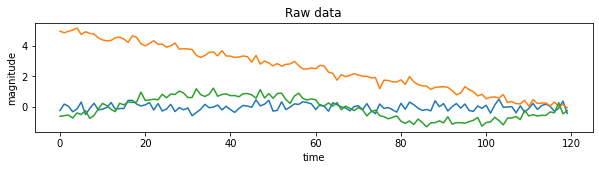

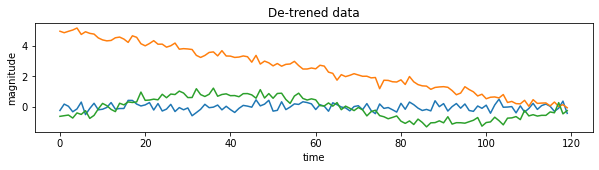

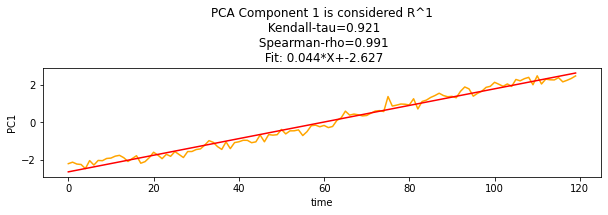

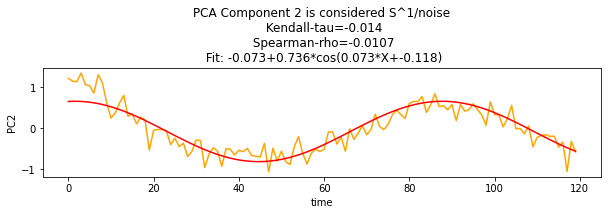

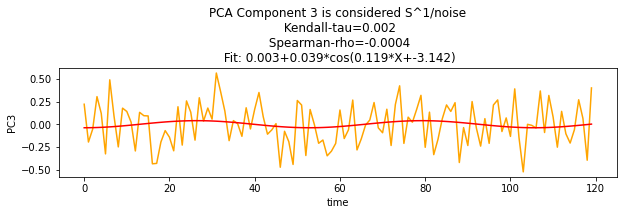

In [3]:
#SIGNAL: (noise, -2t+noise, sin(7t)+noise )
X_d1 = np.random.normal(size=(3,120),scale=0.2)
X_d1[0,:] = X_d1[0,:]#+np.linspace(0,10,100)
X_d1[1,:] = X_d1[1,:]+(-5)*np.linspace(-1,0,120)#+np.linspace(0,10,100)
X_d1[2,:] = X_d1[2,:]+1*np.sin(7*np.linspace(-1,0,120))
mix_d1 = MixedCoordinates(data_matrix=X_d1.T,n_comp=3,detrend=False,get_fits=True,kendall_threshold=0.5)
#mix_d1_detrended = MixedCoordinates(data_matrix=X_d1,n_comp=5,detrend=True,get_fits=True)

#print(mix_d1['detrended_matrix'])

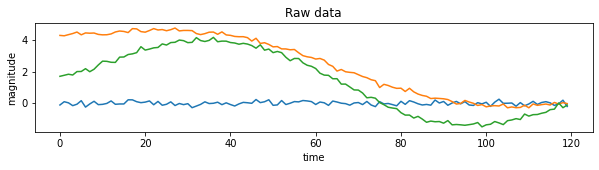

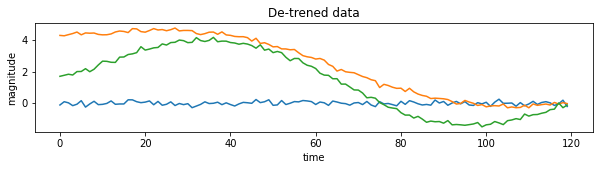

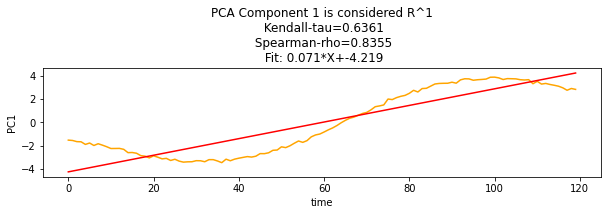

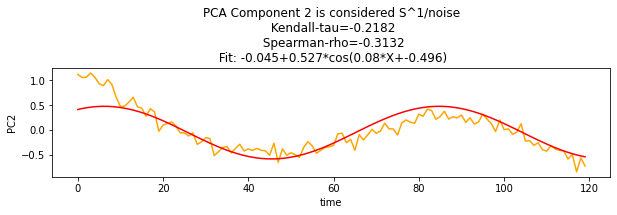

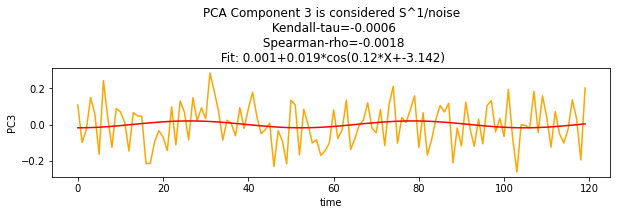

In [4]:
#SIGNAL: (noise, -2t+sin(7t)+noise, -t+2sin(7t)+noise )
X_d1 = np.random.normal(size=(3,120),scale=0.1)
X_d1[0,:] = X_d1[0,:]#+np.linspace(0,10,100)
X_d1[1,:] = X_d1[1,:]+(-5)*np.linspace(-1,0,120)+1*np.sin(7*np.linspace(-1,0,120))#+np.linspace(0,10,100)
X_d1[2,:] = X_d1[2,:]+(-3)*np.linspace(-1,0,120)+2*np.sin(7*np.linspace(-1,0,120))
mix_d1 = MixedCoordinates(data_matrix=X_d1.T,n_comp=3,detrend=False,get_fits=True,kendall_threshold=0.5)
#mix_d1_detrended = MixedCoordinates(data_matrix=X_d1,n_comp=5,detrend=True,get_fits=True)

#print(mix_d1['detrended_matrix'])